# Cucker smale example
The idea is to see if having a two steps learning enables us to reduce the number of point on the dataset.

## Generate the dataset

In [89]:
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt

def buildMatrixA(y):
    """ Build the small matrix A in 
    A_big = [[0,    I   ],
             [0, A_small]]
    """
    dim = y.shape[0]
    interationCoefficient = lambda yi, yj:  1. / ( 1. + (yi - yj)**2 )
    A_small = np.zeros( (dim, dim) )
    for i in range(dim):
        for j in range(dim):
            if i == j:
                sum_coeff = sum( [interationCoefficient(yi=y[i], yj=y[k]) for k in range(dim)] )
                A_small[i, j] = -1 / dim *  sum_coeff
            else:
                A_small[i, j] = 1 / dim * interationCoefficient(yi=y[i], yj=y[j])

    return A_small

def computeValueFunctionSDRE(B, Q, R, barx_i, dim):
    A_small = buildMatrixA(y=barx_i[0 : dim])
    A = np.block( [[ np.zeros((dim, dim)), np.eye(dim, dim)], [np.zeros((dim, dim)), A_small]] )
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)
    V = 0.5 * (barx_i.T @ P @ barx_i)
    gradV = P @ barx_i
    return P, V, gradV

In [90]:
dim = 5
n_samples = 50
x = np.random.uniform( -3, 3, size=(2 * dim, 1, n_samples) )

B = np.block( [[np.zeros((dim,dim))], [np.eye(dim,dim)]] )
Q = 1 / dim * np.eye(2 * dim, 2 * dim)
R = 1 / dim * np.eye(dim, dim)

In [91]:
import ray
ray.shutdown()
ray.init()

2022-02-19 16:10:32,065	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:6379',
 'object_store_address': '/tmp/ray/session_2022-02-19_16-10-30_652390_25723/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-19_16-10-30_652390_25723/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-19_16-10-30_652390_25723',
 'metrics_export_port': 60215,
 'node_id': '70d875b556719836c763d00d68a9df04bb3505611903e7a64b0bf858'}

In [92]:
@ray.remote
def generateDatasetValues(x_chunk):
    inds = np.triu_indices( 2 * dim )
    resu_P = []
    resu_V = []
    resu_gradV = []
    total_sample = x_chunk.shape[2]
    for sample in range( total_sample ):
        if sample % 500 == 0:
            print('%d / %d'%(sample, total_sample))
        barx_i = x_chunk[:, :, sample]
        P, V, gradV = computeValueFunctionSDRE(B, Q, R, barx_i, dim)
        resu_P.append( P[inds] )
        resu_V.append(V)
        resu_gradV.append(gradV)

    return resu_P, resu_V, resu_gradV

In [93]:
input_params = []
chunk_size = 10
n_chunk = int( n_samples / chunk_size )
for i in range( n_chunk ):
    idx_start = i * chunk_size
    idx_end = (i + 1) * chunk_size
    print( idx_start, idx_end)
    input_params.append( x[:, :, idx_start : idx_end] )

0 10
10 20
20 30
30 40
40 50


In [94]:
resu = []

for x_chunk in input_params:
    resu_exp = generateDatasetValues.remote(
        x_chunk
    )
    resu.append( resu_exp )

resu = ray.get( resu )

(pid=26211) 0 / 10
(pid=26215) 0 / 10
(pid=26214) 0 / 10
(pid=26212) 0 / 10
(pid=26209) 0 / 10


In [95]:
resu_P = []
resu_V = []
resu_gradV = []

for resu_chunk in resu:
    chunk_P, chunk_V, chunk_gradV = resu_chunk
    resu_P += chunk_P
    resu_V += chunk_V
    resu_gradV += chunk_gradV

resu_P = np.stack( resu_P )
resu_V = np.stack( resu_V )[:,:,0]
resu_gradV = np.stack( resu_gradV )[:,:,0]

In [96]:
np.savetxt( 'sampledPoints.csv', np.squeeze( x ).T, fmt='%.8f' )
np.savetxt( 'matrixFunction.csv', resu_P, fmt='%.8f' )
np.savetxt( 'valueFunction.csv', resu_V, fmt='%.8f' )
np.savetxt( 'valueFunctionDerivative.csv', resu_gradV, fmt='%.8f' )

## Quick check in 2D

In [438]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)

In [182]:
dim = 1

B = np.block( [[np.zeros((dim,dim))], [np.eye(dim,dim)]] )
Q = 1 / dim * np.eye(2 * dim, 2 * dim)
R = 1 / dim * np.eye(dim, dim)

matrixV = np.zeros( (100, 100) )

for i, xi in enumerate(x):
    if i % 20 == 0:
        print(i)
    for j, yi in enumerate(y):
        barx_i = np.array([xi, yi])
        _, V, _ = computeValueFunctionSDRE(B, Q, R, barx_i.reshape(-1, 1), dim)
        matrixV[i, j] = V.item()

0
20
40
60
80


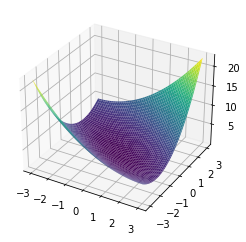

In [183]:
# true solutin
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, matrixV, cmap='viridis');

In [184]:
from itertools import product
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xinput = np.array([barx_i for barx_i in list( product(x, y) )])

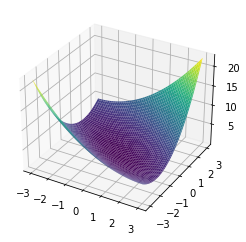

In [185]:
P = np.array([[2., 1], [1, 1.]])
Z = 0.5 * np.einsum('ni, ij, nj -> n', xinput, P, xinput).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

## High dim experiment

In [97]:
from pde import NeuralNet, LinearQuadraticRegulator, GenerateData, NonLinear, CuckerSmale
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [98]:
output_layer = sum( [i for i in range(2 * dim + 1)] )
print(output_layer)
quadraticForm = True
layers = [2 * dim, 50, 50, 50, output_layer if quadraticForm else 1]
network = NeuralNet( layers, quadraticForm=quadraticForm, useAdditionalModel=False)
gamma = {'data': 1., 'gradient': 1., 'residual': 0, 'matrix': 1.}
pde = CuckerSmale( network, gamma, dim=dim )

55


In [99]:
resu = pde.train(
    interiorPointCount=1,
    dataPointCount=50,
    #lrs=[1e-2, 1e-3],
    lrs=[1e-2, 1e-3, 1e-4],
    iterations=[1000, 5000, 15000],
    useTestData=True
    )

xInt:  torch.Size([1, 10])
xData:  torch.Size([40, 10])
xDataTest:  torch.Size([10, 10])
0 / 21000 (0 / 1000), lr:1.0e-02, loss:2.09e+02 (data: 1.98e+02, grad: 1.06e+01, res: 0.00e+00, mat: 3.71e-01)
yDataTest tensor([[-2.0527],
        [ 0.3609],
        [ 1.7481],
        [ 2.6968],
        [-9.3258]], grad_fn=<SliceBackward>)
yTrueTest tensor([[2.7109],
        [3.1288],
        [5.7988],
        [4.8041],
        [1.8274]], dtype=torch.float64)
lossDataTest: 2.80e+01
lossGradientTest: 6.24e+00
10 / 21000 (10 / 1000), lr:1.0e-02, loss:1.12e+01 (data: 9.53e+00, grad: 1.60e+00, res: 0.00e+00, mat: 5.65e-02)
yDataTest tensor([[ 4.7309],
        [ 0.6449],
        [-1.8738],
        [ 2.4202],
        [ 1.0737]], grad_fn=<SliceBackward>)
yTrueTest tensor([[2.7109],
        [3.1288],
        [5.7988],
        [4.8041],
        [1.8274]], dtype=torch.float64)
lossDataTest: 2.22e+01
lossGradientTest: 1.30e+00
20 / 21000 (20 / 1000), lr:1.0e-02, loss:3.11e+00 (data: 2.61e+00, grad: 4.82e-01

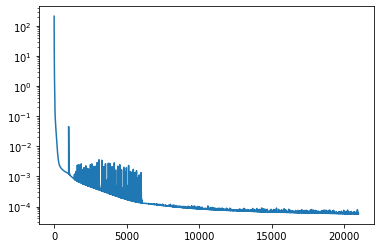

In [100]:
plt.plot( resu['loss'] )
plt.yscale('log')

## Compute trajectories

In [101]:
import scipy.linalg
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_samples = 1
T = 10
dt = 0.1
barx = 2 * torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)

B = torch.vstack( [torch.zeros((dim, dim)), torch.eye(dim)] ).to(device).float()
Q = 1 / dim * torch.eye(2*dim, 2*dim).to(device).float()
R = 1 / dim * torch.eye(dim, dim).to(device).float()
beta = pde.beta

Bnp = B.cpu().numpy()
Qnp = Q.cpu().numpy()
Rnp = R.cpu().numpy()

In [102]:
def computeTrajectoriesNeuralNet(barx, dim, pde):
    resu = {}
    save_u = {}
    value_function = []
    for sample in range(barx.shape[0]):
        print(sample)
        new_barx_i = barx[sample, :]
        save_barx_i = np.zeros( (100, 2 * dim) )
        save_u_i = np.zeros( (100, dim) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            # compute the control
            barx_i = new_barx_i
            gradV = pde.network.computeValueFunctionDerivative( barx_i.reshape(1, -1) ).T
            baru = - 1 / (2 * beta) * torch.inverse(R) @ B.T @ gradV
            save_barx_i[i] = new_barx_i.detach().cpu().numpy()
            save_u_i[i] = np.squeeze(  baru.detach().cpu().numpy() )

            # compute the dynamics
            A_small = buildMatrixA(y=barx_i[0 : dim])
            A = torch.tensor( np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] ) ).float().to(device)
            new_barx_i = barx_i + A @ barx_i * dt + torch.squeeze(B @ baru) * dt
            
        # save the value function
        vi = np.sum( np.trapz(y=save_barx_i**2, dx=dt, axis=0) ) + np.sum( np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt, axis=0) )

        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
        value_function.append( vi )

    return resu, save_u, value_function

def computeTrajectoriesSDRE(barx, dim):
    resu = {}
    save_u = {}
    value_function = []
    for sample in range(barx.shape[0]):
        print(sample)
        new_barx_i = barx[sample, :].cpu().detach().numpy()
        save_barx_i = np.zeros( (100, 2 * dim) )
        save_u_i = np.zeros( (100, dim) )
        
        for i, t in enumerate( np.arange(0, T, dt) ):
            barx_i = new_barx_i
            A_small = buildMatrixA(y=barx_i[0 : dim])
            A = np.block( [[ np.zeros((dim, dim)), np.eye(dim)], [np.zeros((dim, dim)), A_small]] )

            # compute the control
            P = scipy.linalg.solve_continuous_are(A, Bnp, Qnp, Rnp)
            baru = - 1 / (2 * beta) * np.linalg.inv(Rnp) @ Bnp.T @ P @ barx_i
            save_barx_i[i] = new_barx_i
            save_u_i[i] = baru
            
            # compute the dynamics
            new_barx_i = barx_i + A @ barx_i * dt + np.squeeze(Bnp @ baru) * dt
            
        # save the value function
        vi = np.sum( np.trapz(y=save_barx_i**2, dx=dt, axis=0) ) + np.sum( np.trapz(y=np.squeeze( save_u_i**2 ), dx=dt, axis=0) )

        resu[sample] = save_barx_i
        save_u[sample] = save_u_i
        value_function.append( vi )

    return resu, save_u, value_function

In [103]:
def plotTrajectories():
    fig, axs = plt.subplots(3, 3, figsize=(20, 12))

    ax = axs[0, 0]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')
    ax.set_title('Neural network inference')

    ax = axs[0, 1]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), resu_sdre[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')
    ax.set_title('SDRE');

    ax = axs[0, 2]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] - resu_sdre[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')
    ax.set_title('NN - SDRE');

    ax = axs[1, 0]
    for i in range(dim, 2 * dim):
        ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')
    ax.set_title('Neural network inference')

    ax = axs[1, 1]
    for i in range(dim, 2 * dim):
        ax.plot( np.linspace(0, T, 100), resu_sdre[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')
    ax.set_title('SDRE')

    ax = axs[1, 2]
    for i in range(dim, 2 * dim):
        ax.plot( np.linspace(0, T, 100), resu_nn[0][:, i] - resu_sdre[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')
    ax.set_title('NN - SDRE')

    ax = axs[2, 0]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), save_u_nn[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Control')
    ax.set_title('Neural network inference')

    ax = axs[2, 1]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), save_u_sdre[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Control')
    ax.set_title('SDRE')

    ax = axs[2, 2]
    for i in range(dim):
        ax.plot( np.linspace(0, T, 100), save_u_nn[0][:, i] - save_u_sdre[0][:, i] )
    ax.set_xlabel('Time')
    ax.set_ylabel('Control')
    ax.set_title('NN - SDRE')

    fig.tight_layout();

In [104]:
barx = torch.tensor( np.hstack( [np.linspace(1, 2.5, 5), np.linspace(1, 2.5, 5)] ), requires_grad=True).reshape(1, -1).float()

In [105]:
# import pickle

# info_dict = {'pde': pde}

# with open('pde_data.pickle', 'wb') as handle:
#     pickle.dump(info_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [106]:
# np.savetxt(
#     'pde_data_trajectories.csv',
#     np.vstack( [np.linspace(0, T, 100).reshape(1, 100), resu_nn[0].T]).T,
#     fmt='%.8f'
#     )

# np.savetxt(
#     'pde_data_control.csv',
#     np.vstack( [np.linspace(0, T, 100).reshape(1, 100), save_u_nn[0].T]).T,
#     fmt='%.8f'
#     )

0
0


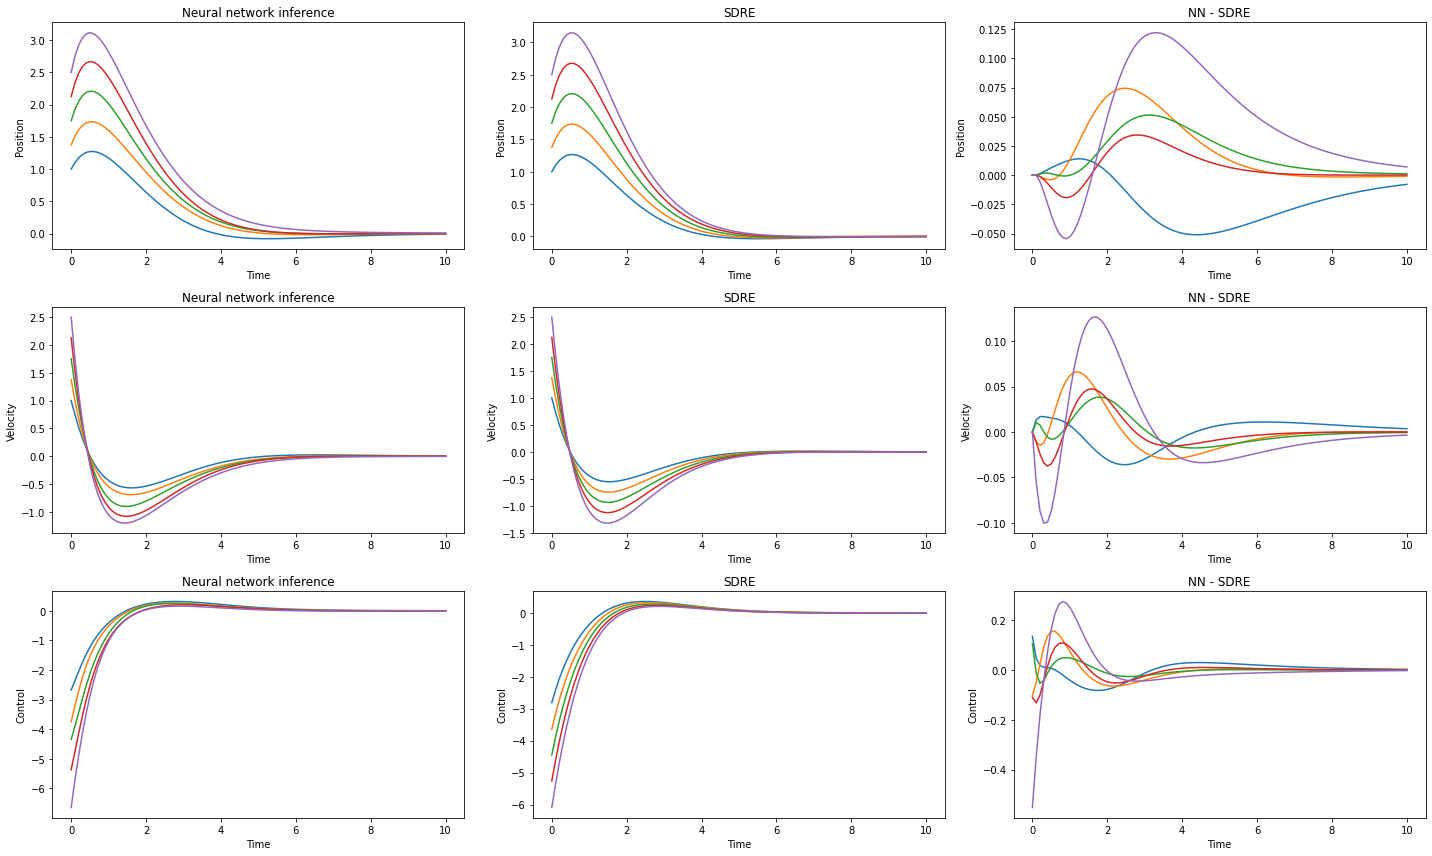

In [107]:
resu_nn, save_u_nn, v_nn = computeTrajectoriesNeuralNet( barx, dim, pde )
resu_sdre, save_u_sdre, v_sdre = computeTrajectoriesSDRE( barx, dim )
plotTrajectories()

## Check the residual

In [123]:
# Compute the value function
n_samples = 1000
barx = 1 - 2 * torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)

In [124]:
# for the Neural net (which is a consistant function)
pde.computeHamiltonJacobiEquation(barx, pde.network.computeValueFunctionDerivative(barx) ).mean()

tensor(-0.0146, grad_fn=<MeanBackward0>)

In [20]:
# the SDRE should be 0 if its gradV = Px
def generateDatasetValues(x_chunk):
    inds = np.triu_indices( 2 * dim )
    resu_P = []
    resu_V = []
    resu_gradV = []
    total_sample = x_chunk.shape[0]
    for sample in range( total_sample ):
        if sample % 500 == 0:
            print('%d / %d'%(sample, total_sample))
        barx_i = x_chunk[sample]
        P, V, gradV = computeValueFunctionSDRE(Bnp, Qnp, Rnp, barx_i, dim)
        resu_P.append( P[inds] )
        resu_V.append(V)
        resu_gradV.append(gradV)

    return resu_P, resu_V, resu_gradV

In [21]:
resu_P, resu_V, resu_gradV = generateDatasetValues(barx.cpu().detach().numpy())

0 / 1000
500 / 1000


In [22]:
# for the SDRE - which is not excatly the SDRE but gradV = Px
pde.computeHamiltonJacobiEquation(barx, torch.tensor(resu_gradV).to(device).float() ).mean()

tensor(-1.0401e-08, grad_fn=<MeanBackward0>)

## Second learning

In [151]:
saved_weights = copy.deepcopy( pde.network.state_dict() )

In [152]:
# second training
gamma = {'data': 0., 'gradient': 0., 'residual': 1, 'matrix': 0.}
pdeResidual = CuckerSmale( network, gamma, dim=dim )

pdeResidual.network.load_state_dict( saved_weights )

<All keys matched successfully>

In [153]:
resu = pdeResidual.train(
    interiorPointCount=10000,
    dataPointCount=5,
    lrs=[1e-3, 1e-4],
    iterations=[10000, 20000],
    useTestData=True
    )

xInt:  torch.Size([10000, 10])
xData:  torch.Size([4, 10])
xDataTest:  torch.Size([1, 10])
0 / 30000 (0 / 10000), lr:1.0e-03, loss:6.22e-01 (data: 0.00e+00, grad: 0.00e+00, res: 6.22e-01, mat: 0.00e+00)
yDataTest tensor([[3.4867]], grad_fn=<SliceBackward>)
yTrueTest tensor([[3.6686],
        [2.9698],
        [3.9515],
        [3.0817],
        [3.9382]], dtype=torch.float64)
lossDataTest: 4.92e+00
lossGradientTest: 7.55e-01
100 / 30000 (100 / 10000), lr:1.0e-03, loss:2.31e-01 (data: 0.00e+00, grad: 0.00e+00, res: 2.31e-01, mat: 0.00e+00)
yDataTest tensor([[2.0673]], grad_fn=<SliceBackward>)
yTrueTest tensor([[3.6686],
        [2.9698],
        [3.9515],
        [3.0817],
        [3.9382]], dtype=torch.float64)
lossDataTest: 9.99e+00
lossGradientTest: 7.24e-01
200 / 30000 (200 / 10000), lr:1.0e-03, loss:1.88e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.88e-01, mat: 0.00e+00)
yDataTest tensor([[1.9181]], grad_fn=<SliceBackward>)
yTrueTest tensor([[3.6686],
        [2.9698],
        [3.95

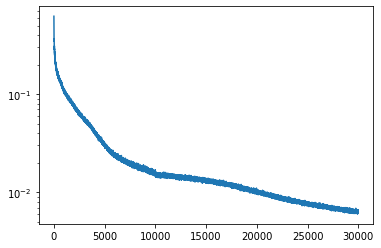

In [154]:
plt.plot( resu['loss'] )
plt.yscale('log')

In [218]:
n_samples = 1
barx = 2 * torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)

In [253]:
barx = torch.tensor( np.hstack( [np.linspace(1, 2.5, 5), np.linspace(1, 2.5, 5)] ), requires_grad=True).reshape(1, -1).float()

0
0


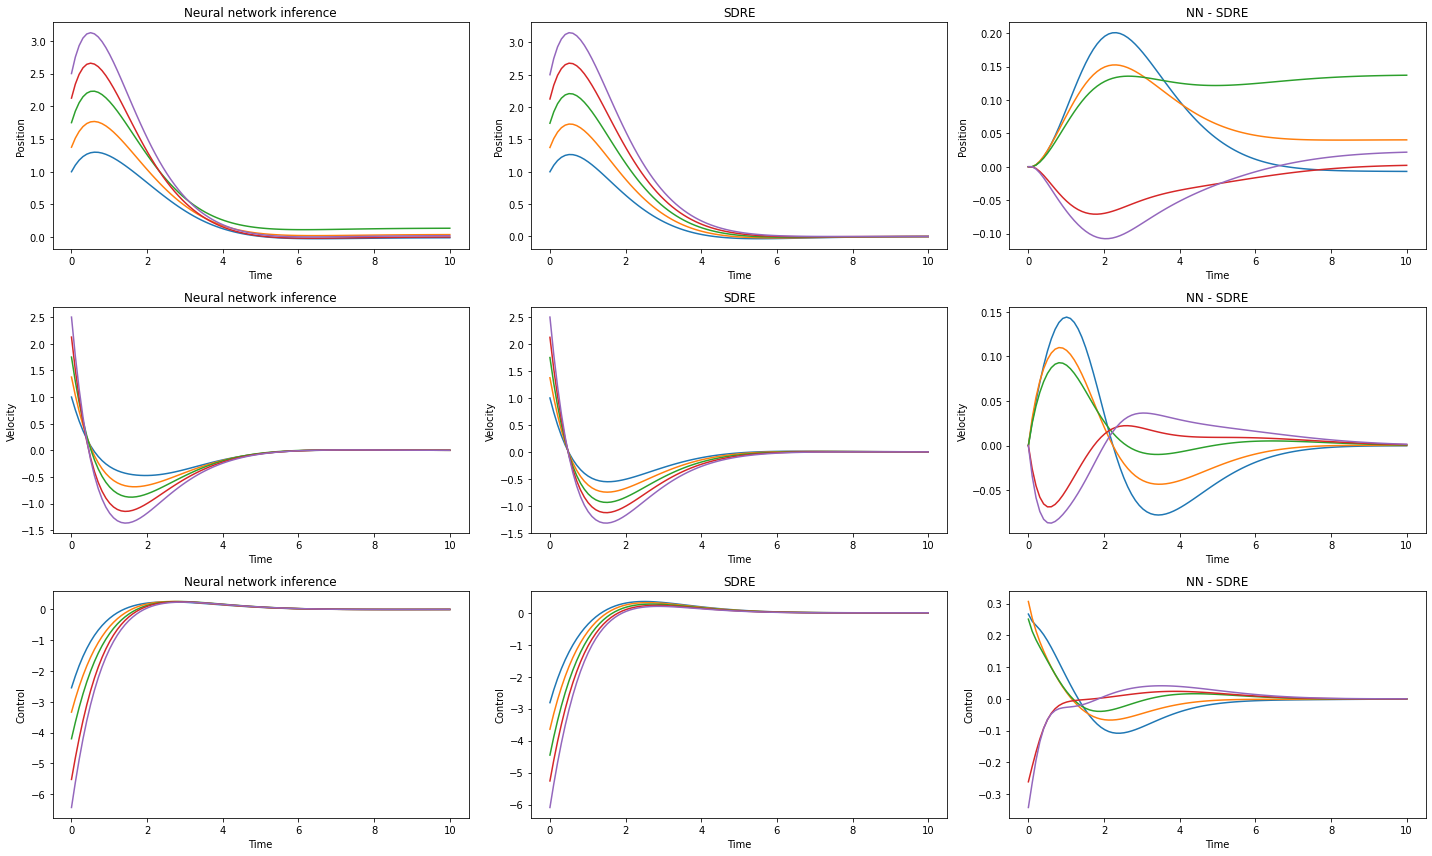

In [254]:
resu_nn, save_u_nn, v_nn = computeTrajectoriesNeuralNet( barx, dim, pdeResidual )
resu_sdre, save_u_sdre, v_sdre = computeTrajectoriesSDRE( barx, dim )
plotTrajectories()

In [217]:
with open('pde_residual.pickle', 'rb') as handle:
    info_dict = pickle.load(handle)

pdeResidual = info_dict['pde']

In [172]:
import pickle

info_dict = {'pde': pdeResidual}

with open('pde_residual.pickle', 'wb') as handle:
    pickle.dump(info_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [255]:
np.savetxt(
    'pde_residual_trajectories.csv',
    np.vstack( [np.linspace(0, T, 100).reshape(1, 100), resu_nn[0].T]).T,
    fmt='%.8f'
    )

np.savetxt(
    'pde_residual_control.csv',
    np.vstack( [np.linspace(0, T, 100).reshape(1, 100), save_u_nn[0].T]).T,
    fmt='%.8f'
    )

In [23]:
n_samples = 1000
barx = 1 - 2 * torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)

In [24]:
# for the Neural net (which is a consistant function)
pde.computeHamiltonJacobiEquation(barx, pde.network.computeValueFunctionDerivative(barx) ).mean()

tensor(-0.1356, device='cuda:0', grad_fn=<MeanBackward0>)

In [163]:
# Compute the value function
n_samples = 100
barx = 1 - 2 * torch.rand((n_samples, 2 * dim), requires_grad=True).to(device)

In [164]:
ray.shutdown()
ray.init()

2022-02-05 21:21:37,792	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:6379',
 'object_store_address': '/tmp/ray/session_2022-02-05_21-21-36_392799_67795/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-05_21-21-36_392799_67795/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-05_21-21-36_392799_67795',
 'metrics_export_port': 64485,
 'node_id': 'dab130a0ed577dacd41294cded106b63516e264523b62a1cef475db8'}

In [165]:
@ray.remote
def generateValueFunctionNeuralNet(x_chunk):
    _, _, v_nn = computeTrajectoriesNeuralNet( x_chunk, dim, pde )
    return v_nn

@ray.remote
def generateValueFunctionSDRE(x_chunk):
    _, _, v_nn = computeTrajectoriesSDRE( x_chunk, dim )
    return v_nn

In [166]:
input_params = []
chunk_size = 5
n_chunk = int( n_samples / chunk_size )
for i in range( n_chunk ):
    idx_start = i * chunk_size
    idx_end = (i + 1) * chunk_size
    print( idx_start, idx_end)
    input_params.append( barx[idx_start : idx_end] )

0 5
5 10
10 15
15 20
20 25
25 30
30 35
35 40
40 45
45 50
50 55
55 60
60 65
65 70
70 75
75 80
80 85
85 90
90 95
95 100


In [167]:
resu = []
resu_nn = []

for x_chunk in input_params:
    resu_exp = generateValueFunctionSDRE.remote(
        x_chunk
    )
    resu.append( resu_exp )

    resu_exp_nn = generateValueFunctionNeuralNet.remote(
        x_chunk
    )
    resu_nn.append( resu_exp_nn )

resu = ray.get( resu )
resu_nn = ray.get( resu_nn )

(pid=70209) 0
(pid=70212) 0
(pid=70208) 0
(pid=70203) 0
(pid=70204) 0
(pid=70209) 1
(pid=70212) 1
(pid=70203) 1
(pid=70204) 1
(pid=70209) 2
(pid=70209) 3
(pid=70209) 4
(pid=70212) 2
(pid=70212) 3
(pid=70212) 4
(pid=70208) 1
(pid=70208) 2
(pid=70208) 3
(pid=70208) 4
(pid=70203) 2
(pid=70203) 3
(pid=70203) 4
(pid=70204) 2
(pid=70204) 3
(pid=70204) 4
(pid=70207) 0
(pid=70207) 1
(pid=70210) 0
(pid=70210) 1
(pid=70205) 0
(pid=70205) 1
(pid=70211) 0
(pid=70211) 1
(pid=70206) 0
(pid=70206) 1
(pid=70207) 2
(pid=70210) 2
(pid=70205) 2
(pid=70211) 2
(pid=70206) 2
(pid=70209) 0
(pid=70212) 0
(pid=70208) 0
(pid=70203) 0
(pid=70204) 0
(pid=70210) 3
(pid=70205) 3
(pid=70206) 3
(pid=70209) 1
(pid=70209) 2
(pid=70212) 1
(pid=70208) 1
(pid=70208) 2
(pid=70203) 1
(pid=70204) 1
(pid=70204) 2
(pid=70204) 3
(pid=70207) 3
(pid=70210) 4
(pid=70205) 4
(pid=70211) 3
(pid=70211) 4
(pid=70206) 4
(pid=70207) 4
(pid=70209) 3
(pid=70209) 4
(pid=70209) 0
(pid=70212) 2
(pid=70208) 3
(pid=70208) 4
(pid=70208) 0
(pid=7

In [168]:
print('Value function SDRE: %.2f' %np.array(resu).sum() )
print('Value function Neural Net: %.2f' %np.array(resu_nn).sum() )

Value function SDRE: 493.62
Value function Neural Net: 523.68


# Residual only

In [285]:
output_layer = sum( [i for i in range(2 * dim + 1)] )
print(output_layer)
quadraticForm = False
layers = [2 * dim, 50, 50, 50, output_layer if quadraticForm else 1]
network = NeuralNet( layers, quadraticForm=quadraticForm, useAdditionalModel=False)

55


In [286]:
# second training
gamma = {'data': 0., 'gradient': 0., 'residual': 1, 'matrix': 0.}
pdeResidual = CuckerSmale( network, gamma, dim=dim )

In [294]:
resu = pdeResidual.train(
    interiorPointCount=10000,
    dataPointCount=5,
    lrs=[1e-3, 1e-4],
    iterations=[1000, 2000],
    useTestData=True
    )

xInt:  torch.Size([10000, 10])
xData:  torch.Size([4, 10])
xDataTest:  torch.Size([1, 10])
0 / 3000 (0 / 1000), lr:1.0e-03, loss:7.48e-03 (data: 0.00e+00, grad: 0.00e+00, res: 7.48e-03, mat: 0.00e+00)
yDataTest tensor([[3.0981]], grad_fn=<SliceBackward>)
yTrueTest tensor([[5.4441],
        [4.1264],
        [3.6086],
        [8.2911],
        [3.4909]], dtype=torch.float64)
lossDataTest: 5.79e+00
lossGradientTest: 5.23e-01
100 / 3000 (100 / 1000), lr:1.0e-03, loss:7.70e-03 (data: 0.00e+00, grad: 0.00e+00, res: 7.70e-03, mat: 0.00e+00)
yDataTest tensor([[2.5087]], grad_fn=<SliceBackward>)
yTrueTest tensor([[5.4441],
        [4.1264],
        [3.6086],
        [8.2911],
        [3.4909]], dtype=torch.float64)
lossDataTest: 7.89e+00
lossGradientTest: 5.51e-01
200 / 3000 (200 / 1000), lr:1.0e-03, loss:7.73e-03 (data: 0.00e+00, grad: 0.00e+00, res: 7.73e-03, mat: 0.00e+00)
yDataTest tensor([[2.4690]], grad_fn=<SliceBackward>)
yTrueTest tensor([[5.4441],
        [4.1264],
        [3.6086],
 

In [295]:
barx = torch.tensor( np.hstack( [np.linspace(1, 2.5, 5), np.linspace(1, 2.5, 5)] ), requires_grad=True).reshape(1, -1).float()

0
0


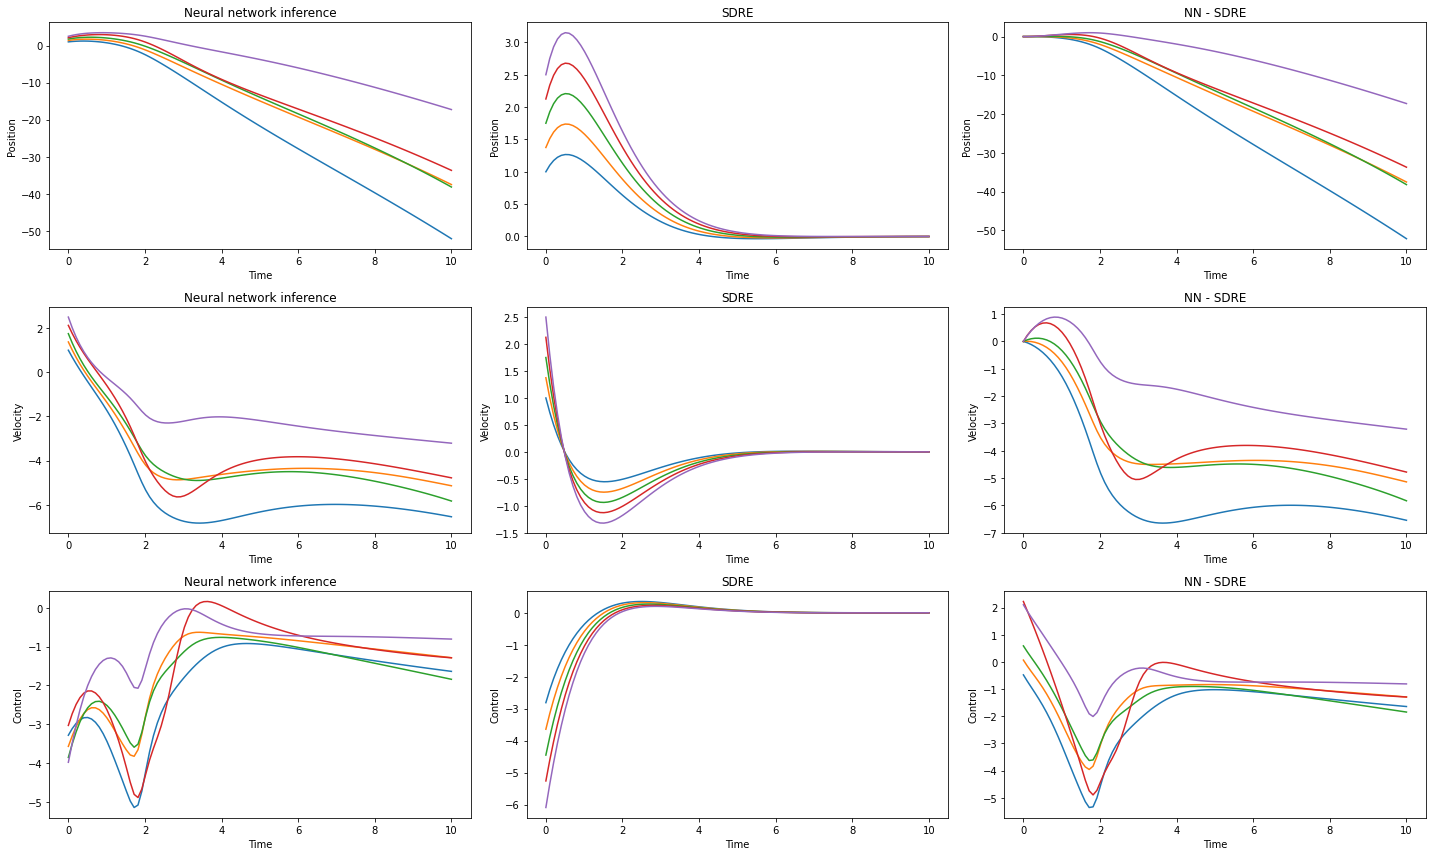

In [296]:
resu_nn, save_u_nn, v_nn = computeTrajectoriesNeuralNet( barx, dim, pdeResidual )
resu_sdre, save_u_sdre, v_sdre = computeTrajectoriesSDRE( barx, dim )
plotTrajectories()

In [297]:
np.savetxt(
    'pde_residual_invalid_trajectories_ter.csv',
    np.vstack( [np.linspace(0, T, 100).reshape(1, 100), resu_nn[0].T]).T,
    fmt='%.8f'
    )

np.savetxt(
    'pde_residual_invalid_control_ter.csv',
    np.vstack( [np.linspace(0, T, 100).reshape(1, 100), save_u_nn[0].T]).T,
    fmt='%.8f'
    )

In [301]:
df_res_invalid = pd.read_csv('experiments/feb/pde_invalid_residual_control.csv', header=None)

In [303]:
df_res_invalid.to_numpy().shape

(100, 11)

In [307]:
np.savetxt(
    'pde_residual_invalid_trajectories_bon.csv',
    pd.read_csv('experiments/feb/pde_invalid_residual_trajectory.csv', header=None).to_numpy(),
    fmt='%.6f'
    )

np.savetxt(
    'pde_residual_invalid_control_bon.csv',
    pd.read_csv('experiments/feb/pde_invalid_residual_control.csv', header=None).to_numpy(),
    fmt='%.8f'
    )